In [0]:
import tarfile
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import statistics

In [0]:
fname = "lenses.tgz"
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

In [3]:
cd lenses

/content/lenses


In [4]:
ls

no_sub/  sub/


In [0]:
import glob

In [0]:
sub_img = []
for img in glob.glob("sub/*.jpg"):
    n = cv2.imread(img)
    sub_img.append(n)

In [0]:
no_sub_img = []
for img in glob.glob("no_sub/*.jpg"):
    n = cv2.imread(img)
    no_sub_img.append(n)

In [8]:
len(no_sub_img)

5000

In [0]:
overall_dataset = []
for i in sub_img:
    overall_dataset.append((i,0))

for i in no_sub_img:
    overall_dataset.append((i,1))

In [0]:
import random
random.shuffle(overall_dataset)

In [0]:
data = [i[0] for i in overall_dataset]
labels = [i[1] for i in overall_dataset]

In [0]:
train_data = torch.from_numpy(np.array(data[:7500]).reshape(-1,3,150,150)).type(torch.FloatTensor).cuda()
train_labels = torch.from_numpy(np.array(labels[:7500])).type(torch.LongTensor).cuda()

In [0]:
train_mean = train_data.mean()
train_std = train_data.std()

In [0]:
train_data_norm = (train_data - train_mean)/train_std

In [0]:
valid_data = data[7500:]
valid_labels = labels[7500:]

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.c1 = nn.Sequential(
                    nn.Conv2d(3,6,5),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(6),
                    nn.Dropout(0.25,inplace=True)
        )

        self.c2 = nn.Sequential(
                   nn.MaxPool2d(2,2),
                   nn.Conv2d(6,16,5),
                   nn.ReLU(inplace=True),
                   nn.BatchNorm2d(16),
                   nn.Dropout(0.25,inplace=True)
        )

        self.fc = nn.Sequential(
                    nn.Linear(76176, 1200),
                    nn.ReLU(inplace=True),
                    nn.Linear(1200,200),
                    nn.ReLU(inplace=True),
                    nn.Linear(200,2)

        )

    def forward(self,x):
        x = self.c1(x)
        x = self.c2(x)
        x = x.view(-1,76176)
        x = self.fc(x)
        return x

In [0]:
net = Net().cuda()

#TRAINING TIME

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)

In [52]:
loss_curve = []

for epoch in range(10):
    for d in range(75):
        batch_train_data_curr = train_data_norm[d*100:d*100+100]
        batch_train_label_curr = train_labels[d*100:d*100+100]

        optimizer.zero_grad()

        outputs = net(batch_train_data_curr)

        loss = criterion(outputs, batch_train_label_curr)

        loss.backward()
        optimizer.step()

        if(d%10 == 0):
            loss_curve.append(loss.item())
            print("EPOCH IS {}\n AND CURRENT LOSS IS {}/n".format(epoch, loss.item()))

EPOCH IS 0
 AND CURRENT LOSS IS 0.7046012282371521/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.7019986510276794/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.7058584094047546/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.681800127029419/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.6883677840232849/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.6744093894958496/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.6816037893295288/n
EPOCH IS 0
 AND CURRENT LOSS IS 0.6786708831787109/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6834112405776978/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6737121343612671/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6763585805892944/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.644680380821228/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6701493263244629/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6520887613296509/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6542238593101501/n
EPOCH IS 1
 AND CURRENT LOSS IS 0.6502737998962402/n
EPOCH IS 2
 AND CURRENT LOSS IS 0.6632287502288818/n
EPOCH IS 2
 AND CURRENT LOSS IS 0.6631911396980286/n
EPOCH IS 2
 AND CURRENT LOSS IS 0.64978373050689

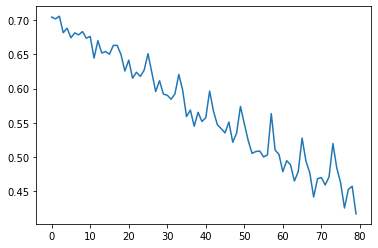

In [53]:
plt.plot(loss_curve)

In [0]:
count = 0
for z,i in enumerate(valid_data):
    j = torch.from_numpy(i.reshape(-1,3,150,150)).type(torch.FloatTensor).cuda()
    j = (j-train_mean)/train_std
    a = net(j)
    _,b = torch.max(a,1)
    if(b.item()==valid_labels[z]):
        count +=1
    

In [0]:
count /= 2500

In [56]:
count

0.6508